TransE

In [5]:
import ampligraph
import numpy as np
import pandas as pd
import tensorflow as tf
from ampligraph.datasets import load_fb15k_237
from ampligraph.evaluation import train_test_split_no_unseen, evaluate_performance, mr_score, mrr_score, hits_at_n_score
from ampligraph.discovery import query_topn, discover_facts, find_clusters
from ampligraph.latent_features import TransE, ComplEx, HolE, DistMult, ConvE, ConvKB
from ampligraph.utils import save_model, restore_model

def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))

print('Ampligraph version: {}'.format(ampligraph.__version__))

Ampligraph version: 1.4.0


In [6]:
from ampligraph.datasets import load_fb15k_237, load_wn18rr, load_yago3_10

In [7]:
import pandas as pd

URL = 'https://ampgraphenc.s3-eu-west-1.amazonaws.com/datasets/freebase-237-merged-and-remapped.csv'
dataset = pd.read_csv(URL, header=None)
dataset.columns = ['subject', 'predicate', 'object']
dataset.head(5)

,subject,predicate,object
0,"queens college, city university of new york",/education/educational_institution/students_gr...,carol leifer
1,digital equipment corporation,/business/business_operation/industry,computer hardware
2,/m/0drtv8,/award/award_ceremony/awards_presented./award/...,laurence mark
3,the departed,/award/award_winning_work/awards_won./award/aw...,leonardo dicaprio
4,marilyn manson,/people/person/profession,actor


In [8]:
print('Total triples in the KG:', dataset.shape)

Total triples in the KG: (310079, 3)


In [9]:
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)

print('Total triples:', dataset.shape)
print('Size of train:', X_train.shape)
print('Size of valid:', X_valid.shape)
print('Size of test:', X_test.shape)

Total triples: (310079, 3)
Size of train: (308579, 3)
Size of valid: (500, 3)
Size of test: (1000, 3)


In [10]:
from ampligraph.latent_features import TransE

model = TransE(k=150,                                                             # embedding size
               epochs=100,                                                        # Num of epochs
               batches_count= 10,                                                 # Number of batches 
               eta=1,                                                             # number of corruptions to generate during training
               loss='pairwise', loss_params={'margin': 1},                        # loss type and it's hyperparameters         
               initializer='xavier', initializer_params={'uniform': False},       # initializer type and it's hyperparameters
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},   # regularizer along with its hyperparameters
               optimizer= 'adam', optimizer_params= {'lr': 0.001},                # optimizer to use along with its hyperparameters
               seed= 0, verbose=True)

model.fit(X_train)

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE-small.pkl')

Average TransE Loss:   0.013576: 100%|████████████████████████████████████████████| 100/100 [02:00<00:00,  1.20s/epoch]


In [11]:
test_triple = ['harrison ford', 
               '/film/actor/film./film/performance/film', 
               'star wars']

triple_score = model.predict(test_triple)

print('Triple of interest:\n', test_triple)
print('Triple Score:\n', triple_score)

Triple of interest:
 ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']
Triple Score:
 [-8.3477955]


In [12]:
import numpy as np
list_of_actors = ['salma hayek', 'carrie fisher', 'natalie portman',  'kristen bell',
                  'mark hamill', 'neil patrick harris', 'harrison ford' ]

# stack it horizontally to create s, p, o
hypothesis = np.column_stack([list_of_actors, 
                              ['/film/actor/film./film/performance/film'] * len(list_of_actors),
                              ['star wars'] * len(list_of_actors),
                             ])

# score the hypothesis
triple_scores = model.predict(hypothesis)

# append the scores column
scored_hypothesis = np.column_stack([hypothesis, triple_scores])
# sort by score in descending order
scored_hypothesis = scored_hypothesis[np.argsort(scored_hypothesis[:, 3])]
scored_hypothesis

array([['natalie portman', '/film/actor/film./film/performance/film',
        'star wars', '-8.2549305'],
       ['harrison ford', '/film/actor/film./film/performance/film',
        'star wars', '-8.3477955'],
       ['carrie fisher', '/film/actor/film./film/performance/film',
        'star wars', '-9.087776'],
       ['neil patrick harris', '/film/actor/film./film/performance/film',
        'star wars', '-9.221671'],
       ['mark hamill', '/film/actor/film./film/performance/film',
        'star wars', '-9.350438'],
       ['kristen bell', '/film/actor/film./film/performance/film',
        'star wars', '-9.354377'],
       ['salma hayek', '/film/actor/film./film/performance/film',
        'star wars', '-9.367626']], dtype='<U39')

In [13]:
print('The number of unique entities:', len(model.ent_to_idx))

The number of unique entities: 14184


In [14]:
subj_corr =  np.column_stack([list(model.ent_to_idx.keys()),
                [test_triple[1]] * len(model.ent_to_idx), 
                [test_triple[2]] * len(model.ent_to_idx)])

print('Subject corruptions:\n', subj_corr)
print('\nSize of subject corruptions:\n', subj_corr.shape)

Subject corruptions:
 [['/m/011xg5' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yd2' '/film/actor/film./film/performance/film' 'star wars']
 ['/m/011yxg' '/film/actor/film./film/performance/film' 'star wars']
 ...
 ['zoology' '/film/actor/film./film/performance/film' 'star wars']
 ['zurich' '/film/actor/film./film/performance/film' 'star wars']
 ['zz top' '/film/actor/film./film/performance/film' 'star wars']]

Size of subject corruptions:
 (14184, 3)


In [15]:
sub_corr_score = model.predict(subj_corr)

In [16]:
sub_rank_worst = np.sum(np.greater_equal(sub_corr_score, triple_score[0])) + 1

print('Assigning the worst rank (to break ties):', sub_rank_worst)

Assigning the worst rank (to break ties): 1529


In [17]:
obj_corr =  np.column_stack([
                [test_triple[0]] * len(model.ent_to_idx),
                [test_triple[1]] * len(model.ent_to_idx), 
                     list(model.ent_to_idx.keys())])


print('Object corruptions:\n', obj_corr)
print('\nSize of object corruptions:\n', obj_corr.shape)

# f. Compute the score of the object corruptions
obj_corr_score = model.predict(obj_corr)

# g. Find the position of hypothesis_score in obj_corr_score to get the obj_rank
obj_rank_worst = np.sum(np.less_equal(triple_score[0], obj_corr_score)) + 1
print('Assigning the worst rank (to break ties):', obj_rank_worst)

Object corruptions:
 [['harrison ford' '/film/actor/film./film/performance/film' '/m/011xg5']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yd2']
 ['harrison ford' '/film/actor/film./film/performance/film' '/m/011yxg']
 ...
 ['harrison ford' '/film/actor/film./film/performance/film' 'zoology']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zurich']
 ['harrison ford' '/film/actor/film./film/performance/film' 'zz top']]

Size of object corruptions:
 (14184, 3)
Assigning the worst rank (to break ties): 832


In [18]:
print('Subject corruption rank:', sub_rank_worst)
print('Object corruption rank:', obj_rank_worst)

Subject corruption rank: 1529
Object corruption rank: 832


In [19]:
from ampligraph.evaluation import evaluate_performance 

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             ranking_strategy='worst')

print('\nRanks:', ranks)

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.77it/s]



Ranks: [[1529  832]]


In [20]:
from ampligraph.evaluation import evaluate_performance 

print('Size of X_test:', X_test.shape)

X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(np.array([test_triple]), 
                             model=model,
                             filter_triples=X_filter)

print(ranks)

Size of X_test: (1000, 3)


100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  5.17it/s]


[[1518  822]]


In [21]:
X_test_small = np.array(
                [['doctorate',
                    '/education/educational_degree/people_with_this_degree./education/education/major_field_of_study',
                    'computer engineering'],

                ['star wars',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['harry potter and the chamber of secrets',
                    '/film/film/estimated_budget./measurement_unit/dated_money_value/currency',
                    'united states dollar'],

                ['star wars', '/film/film/language', 'english language'],
                ['harrison ford', '/film/actor/film./film/performance/film', 'star wars']])


X_filter = np.concatenate([X_train, X_valid, X_test], 0)

ranks = evaluate_performance(X_test_small, 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
print(ranks)

100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:00<00:00, 16.65it/s]


[[   8    9]
 [   1    1]
 [ 109    1]
 [   1    1]
 [1518  822]]


In [22]:
from ampligraph.evaluation import mr_score
print('MR :', mr_score(ranks))

MR : 247.1


In [23]:
from ampligraph.evaluation import mrr_score
print('MRR :', mrr_score(ranks))

MRR : 0.5247160729578209


In [24]:
print('Mean rank after removing the outlier effect: ', np.ceil(1/mrr_score(ranks)))

Mean rank after removing the outlier effect:  2.0


In [25]:
from ampligraph.evaluation import hits_at_n_score
print('hits@1 :', hits_at_n_score(ranks, 1))
print('hits@10 :', hits_at_n_score(ranks, 10))

hits@1 : 0.5
hits@10 : 0.7


In [26]:
# print unique entities
print('Number of unique entities:', len(model.ent_to_idx))

Number of unique entities: 14184


In [27]:
def display_aggregate_metrics(ranks):
    print('Mean Rank:', mr_score(ranks)) 
    print('Mean Reciprocal Rank:', mrr_score(ranks)) 
    print('Hits@1:', hits_at_n_score(ranks, 1))
    print('Hits@10:', hits_at_n_score(ranks, 10))
    print('Hits@100:', hits_at_n_score(ranks, 100))


display_aggregate_metrics(ranks)

Mean Rank: 247.1
Mean Reciprocal Rank: 0.5247160729578209
Hits@1: 0.5
Hits@10: 0.7
Hits@100: 0.7


In [28]:
early_stopping_params = { 'x_valid': X_valid,   # Validation set on which early stopping will be performed
                          'criteria': 'mrr',    # metric to watch during early stopping
                          'burn_in': 150,       # Burn in time, i.e. early stopping checks will not be performed till 150 epochs
                          'check_interval': 50, # After burn in time, early stopping checks will be performed at every 50th epochs (i.e. 150, 200, 250, ...)
                          'stop_interval': 2,   # If the monitored criteria degrades for these many epochs, the training stops. 
                          'corrupt_side':'s,o'  # Which sides to corrupt furing early stopping evaluation (default both subject and obj as described earlier)
                        }

# create a model as earlier
model = TransE(k=100, 
               epochs=10000, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

# call model.fit by passing early stopping params
model.fit(X_train,                                      # training set
          early_stopping=True,                          # set early stopping to true
          early_stopping_params=early_stopping_params)  # pass the early stopping params

# evaluate the model with filter
X_filter = np.concatenate([X_train, X_valid, X_test], 0)
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)
# display the metrics
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


Average TransE Loss:   0.013473 — Best validation (mrr): 0.095524:   9%|▌     | 949/10000 [47:30<7:33:10,  3.00s/epoch]
100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:20<00:00, 49.71it/s]


Mean Rank: 516.5365
Mean Reciprocal Rank: 0.16702902398466046
Hits@1: 0.103
Hits@10: 0.288
Hits@100: 0.5965


In [29]:
# ----------------------
# Generate train/test data
# create train/test/valid splits, train the model and evaluate using train_test_split_no_unseen API
from ampligraph.evaluation import train_test_split_no_unseen
# get the validation set of size 500
test_train, X_valid = train_test_split_no_unseen(dataset.values, 500, seed=0)

# get the test set of size 1000 from the remaining triples
X_train, X_test = train_test_split_no_unseen(test_train, 1000, seed=0)
# ----------------------
# Training:

print('Training set:', X_train.shape)

# Train a KGE model
model = TransE(k=300, 
               epochs=100, 
               eta=1, 
               loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.0001}, 
               seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)
# ----------------------
# Evaluate: 
# Filtered evaluation with ranking strategy assigning worst rank to break ties

from ampligraph.utils import save_model, restore_model
save_model(model, 'TransE.pkl')
model = restore_model('TransE.pkl')

# create the filter 
X_filter = np.concatenate([X_train, X_valid, X_test], 0)

# compute ranks
ranks = evaluate_performance(X_test, 
                             model=model, 
                             filter_triples=X_filter)

# ranks are computed per triple
print('Test set:', X_test.shape)
print('Size of ranks:', ranks.shape)

# Aggregate metrics show the aggregate performance of the model on the test set using a single number
display_aggregate_metrics(ranks)
# ----------------------

Training set: (308579, 3)


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:44<00:00, 22.29it/s]


Test set: (1000, 3)
Size of ranks: (1000, 2)
Mean Rank: 628.915
Mean Reciprocal Rank: 0.17638450293822197
Hits@1: 0.114
Hits@10: 0.2975
Hits@100: 0.554


In [30]:
X_test_movie_languages = X_test[X_test[:, 1] == '/film/film/language']
X_test_movie_languages

array([['the mummy returns', '/film/film/language', 'english language'],
       ['love affair', '/film/film/language', 'english language'],
       ['vicky cristina barcelona', '/film/film/language',
        'spanish language'],
       ['borat', '/film/film/language', 'english language'],
       ['/m/03gyvwg', '/film/film/language', 'japanese language'],
       ['and the band played on', '/film/film/language',
        'english language'],
       ['/m/09gb_4p', '/film/film/language', 'english language'],
       ['from russia with love', '/film/film/language',
        'turkish language'],
       ['titanic', '/film/film/language', 'italian language'],
       ['salt', '/film/film/language', 'english language'],
       ['superman ii', '/film/film/language', 'english language'],
       ['spy game', '/film/film/language', 'english language']],
      dtype=object)

In [31]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter)

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 16.50it/s]


Mean Rank: 308.5416666666667
Mean Reciprocal Rank: 0.3864425781721063
Hits@1: 0.2916666666666667
Hits@10: 0.5833333333333334
Hits@100: 0.75

Size of test set: (12, 3)
Size of ranks: (12, 2)


In [32]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o')

display_aggregate_metrics(ranks)
print('\nSize of test set:', X_test_movie_languages.shape)
print('Size of ranks:', ranks.shape)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 23.19it/s]


Mean Rank: 5.916666666666667
Mean Reciprocal Rank: 0.6084656084656084
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0

Size of test set: (12, 3)
Size of ranks: (12,)


In [33]:
print('The number of corruptions generated per triple is:', len(model.ent_to_idx))

The number of corruptions generated per triple is: 14184


In [34]:
unique_languages = set(X_train[X_train[:, 1] == '/film/film/language'][:, 2])

print('Number of languages in KG:', len(unique_languages))
print('\n', unique_languages)

Number of languages in KG: 61

 {'thai language', 'standard chinese', 'albanian language', 'malay language', 'bulgarian language', 'filipino language', 'hungarian language', 'dutch language', 'mandarin chinese', 'italian language', 'swahili language', 'arabic language', 'german food', 'romanian language', 'norwegian language', 'korean language', 'swedish language', 'england', 'latin language', 'serbo-croatian language', 'american english', 'italian food', 'france', 'indonesian language', 'silent film', 'gujarati language', 'russian language', 'portuguese language', 'hebrew language', 'punjabi language', 'bengali language', 'serbian language', 'greek language', 'spanish language', 'persian language', 'yiddish language', 'tamil language', 'japanese language', 'sinhala language', 'czech language', 'vietnamese language', 'khmer language', 'germany', 'polish language', 'croatian language', 'ukrainian language', 'english language', 'turkish language', 'finnish language', 'french', 'irish', '

In [35]:
ranks = evaluate_performance(X_test_movie_languages, 
                             model=model, 
                             filter_triples=X_filter,
                             corrupt_side='o',
                             entities_subset=list(unique_languages))

display_aggregate_metrics(ranks)

c:\users\sai vamsi\appdata\local\programs\python\python37\lib\site-packages\ampligraph\latent_features\models\EmbeddingModel.py:1329: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if corruption_entities == 'all':
100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:00<00:00, 31.34it/s]


Mean Rank: 5.75
Mean Reciprocal Rank: 0.6085648148148147
Hits@1: 0.5
Hits@10: 0.9166666666666666
Hits@100: 1.0


In [36]:
model = TransE(k=150, epochs=50, eta=1, loss='multiclass_nll', 
               initializer='xavier', initializer_params={'uniform': False},
               regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
               optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
               seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:25<00:00, 38.67it/s]


Mean Rank: 981.118
Mean Reciprocal Rank: 0.12425719647626988
Hits@1: 0.0725
Hits@10: 0.2185
Hits@100: 0.5075


In [38]:
print('The number of unique entities:', len(model.ent_to_idx))
print('The number of unique relations:', len(model.rel_to_idx))
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of relation embeddings:', model.rel_emb.shape)

The number of unique entities: 14184
The number of unique relations: 237
Size of entity embeddings: (14184, 150)
Size of relation embeddings: (237, 150)


In [39]:
model = DistMult(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:24<00:00, 40.26it/s]


Mean Rank: 712.517
Mean Reciprocal Rank: 0.2271655415355942
Hits@1: 0.1575
Hits@10: 0.3545
Hits@100: 0.587


In [40]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of relation embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 150)
Size of relation embeddings: (237, 150)


In [41]:
model = ComplEx(k=150, epochs=50, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.0001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 1, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test, 
                             model=model,
                             filter_triples=X_filter,
                             corrupt_side='s,o',
                             ranking_strategy='worst')
display_aggregate_metrics(ranks)

WARNING - All triples will be processed in the same batch (batches_count=1). When processing large graphs it is recommended to batch the input knowledge graph instead.


100%|██████████████████████████████████████████████████████████████████████████████| 1000/1000 [01:22<00:00, 12.19it/s]


Mean Rank: 598.6655
Mean Reciprocal Rank: 0.22117991371706924
Hits@1: 0.155
Hits@10: 0.3515
Hits@100: 0.6055


In [42]:
print('Size of entity embeddings:', model.ent_emb.shape)
print('Size of relation embeddings:', model.rel_emb.shape)

Size of entity embeddings: (14184, 300)
Size of relation embeddings: (237, 300)


In [43]:
from ampligraph.latent_features import TransE

model = TransE(k=1000, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:13<00:00,  7.32it/s]


Mean Rank: 624.105
Mean Reciprocal Rank: 0.1542283997687143
Hits@1: 0.08
Hits@10: 0.28
Hits@100: 0.525


In [44]:
model = TransE(k=10, epochs=20, eta=1, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 5, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')

display_aggregate_metrics(ranks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:01<00:00, 95.05it/s]


Mean Rank: 987.2
Mean Reciprocal Rank: 0.1070215746493239
Hits@1: 0.055
Hits@10: 0.205
Hits@100: 0.445


In [45]:
model = TransE(k=250, epochs=20, eta=20, loss='multiclass_nll', 
                initializer='xavier', initializer_params={'uniform': False},
                regularizer='LP', regularizer_params= {'lambda': 0.001, 'p': 3},
                optimizer= 'adam', optimizer_params= {'lr': 0.001}, 
                seed= 0, batches_count= 10, verbose=True)

model.fit(X_train)

ranks = evaluate_performance(X_test[::10], 
                             model=model, 
                             filter_triples=X_filter, 
                             corrupt_side='s,o')
display_aggregate_metrics(ranks)

100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:04<00:00, 24.87it/s]


Mean Rank: 577.98
Mean Reciprocal Rank: 0.1572849252974834
Hits@1: 0.095
Hits@10: 0.285
Hits@100: 0.59


In [46]:
from ampligraph.evaluation import select_best_model_ranking

model_class = TransE
param_grid = {
                     "batches_count": [5],
                     "seed": 0,
                     "epochs": [50],
                     "k": [150, 50],
                     "eta": [1, 5],
                     "loss": ["multiclass_nll"],
                     "loss_params": {},
                     "embedding_model_params": {},
                     "regularizer": ["LP"],
                     "regularizer_params": {
                         "p": [3],
                         "lambda": [1e-3]
                      },
                     "optimizer": ["adam"],
                     "optimizer_params":{
                         "lr": 0.001 #lambda: np.random.uniform(0.00001, 0.01)
                     },
                     "verbose": False
                 }
best_model, best_params, best_mrr_train, ranks_test, mrr_test, experimental_history = \
        select_best_model_ranking(model_class, 
                          X_train, 
                          X_valid, 
                          X_test, 
                          param_grid,
                          # max_combinations=2, # performs random search-executes 2 models by randomly choosing params
                          use_filter=True, 
                          verbose=True,
                          early_stopping=True)

4it [06:42, 100.68s/it]


In [47]:
print('MRR of the best model:', best_mrr_train)

MRR of the best model: 0.17919808683755664


In [48]:
# params of the best model
best_params

{'batches_count': 5,
 'seed': 0,
 'epochs': 50,
 'k': 150,
 'eta': 1,
 'loss': 'multiclass_nll',
 'regularizer': 'LP',
 'optimizer': 'adam',
 'verbose': False,
 'optimizer_params': {'lr': 0.001},
 'regularizer_params': {'p': 3, 'lambda': 0.001}}

In [49]:
best_model

In [50]:
experimental_history

[{'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 150,
   'eta': 1,
   'loss': 'multiclass_nll',
   'regularizer': 'LP',
   'optimizer': 'adam',
   'verbose': False,
   'optimizer_params': {'lr': 0.001},
   'regularizer_params': {'p': 3, 'lambda': 0.001}},
  'results': {'mrr': 0.17919808683755664,
   'mr': 495.932,
   'hits_1': 0.116,
   'hits_3': 0.193,
   'hits_10': 0.301}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 150,
   'eta': 5,
   'loss': 'multiclass_nll',
   'regularizer': 'LP',
   'optimizer': 'adam',
   'verbose': False,
   'optimizer_params': {'lr': 0.001},
   'regularizer_params': {'p': 3, 'lambda': 0.001}},
  'results': {'mrr': 0.177284822938332,
   'mr': 516.436,
   'hits_1': 0.11,
   'hits_3': 0.191,
   'hits_10': 0.312}},
 {'model_name': 'TransE',
  'model_params': {'batches_count': 5,
   'seed': 0,
   'epochs': 50,
   'k': 50,
   'eta': 1,
   'loss': 'mu

In [51]:
model = restore_model('TransE.pkl')
X_test_small = np.array([['star wars', '/film/film/language', 'english language'],
                         ['star wars', '/film/film/language', 'java']]) 

model.predict(X_test_small)

array([ -5.6324773, -11.730196 ], dtype=float32)

In [52]:
model.calibrate(X_train, 
                X_neg=None, 
                positive_base_rate=0.5, 
                batches_count=100, 
                epochs=100)

Calibration Loss:   0.393048: 100%|███████████████████████████████████████████████| 100/100 [01:57<00:00,  1.17s/epoch]


In [53]:
model.predict_proba(X_test_small)

array([0.96923953, 0.26725274], dtype=float32)

In [54]:
from ampligraph.discovery import query_topn

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

triples, scores = query_topn(model, top_n=10, 
                             head='missy elliott', 
                             relation='/people/person/profession', 
                             tail=None, 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -9.751303672790527 	 ['missy elliott' '/people/person/profession' 'pianist'] 
Score: -9.78507137298584 	 ['missy elliott' '/people/person/profession' 'songwriter'] 
Score: -10.15805435180664 	 ['missy elliott' '/people/person/profession' 'bandleader'] 
Score: -10.231254577636719 	 ['missy elliott' '/people/person/profession' 'musician'] 
Score: -10.238839149475098 	 ['missy elliott' '/people/person/profession' 'record producer'] 
Score: -10.281855583190918 	 ['missy elliott' '/people/person/profession' 'singer-songwriter'] 
Score: -10.327535629272461 	 ['missy elliott' '/people/person/profession' 'presenter'] 
Score: -10.365259170532227 	 ['missy elliott' '/people/person/profession' 'poet'] 
Score: -10.366982460021973 	 ['missy elliott' '/people/person/profession' 'composer'] 
Score: -10.402355194091797 	 ['missy elliott' '/people/person/profession' 'model'] 


In [55]:
triples, scores = query_topn(model, top_n=10, 
                             head='the departed', 
                             relation=None, 
                             tail='/m/086k8', 
                             ents_to_consider=None, 
                             rels_to_consider=None)

for triple, score in zip(triples, scores):
    print('Score: {} \t {} '.format(score, triple))

Score: -7.1157708168029785 	 ['the departed' '/film/film/production_companies' '/m/086k8'] 
Score: -7.266502380371094 	 ['the departed'
 '/award/award_winning_work/awards_won./award/award_honor/award_winner'
 '/m/086k8'] 
Score: -7.613901138305664 	 ['the departed' '/location/hud_county_place/place' '/m/086k8'] 
Score: -7.797091007232666 	 ['the departed' '/education/educational_institution/campuses' '/m/086k8'] 
Score: -7.8558244705200195 	 ['the departed'
 '/education/educational_institution_campus/educational_institution'
 '/m/086k8'] 
Score: -8.244569778442383 	 ['the departed' '/film/film/produced_by' '/m/086k8'] 
Score: -8.278088569641113 	 ['the departed' '/film/film/written_by' '/m/086k8'] 
Score: -8.314055442810059 	 ['the departed'
 '/celebrities/celebrity/sexual_relationships./celebrities/romantic_relationship/celebrity'
 '/m/086k8'] 
Score: -8.41363525390625 	 ['the departed'
 '/base/popstra/celebrity/dated./base/popstra/dated/participant'
 '/m/086k8'] 
Score: -8.4912271499

In [56]:
from ampligraph.discovery import find_clusters
from sklearn.cluster import KMeans

# restore the previously saved model to save time
model = restore_model('TransE.pkl')

# Get the entities that we want to cluster. Here we use all unique entities
all_entities = np.array(list(set(dataset.values[:, 0]).union(dataset.values[:, 2])))
print('Size of the subset being used for subset generation:', len(all_entities))

# create the clustering algorithm from sklearn
kmeans = KMeans(n_clusters=3, n_init=100, max_iter=500)

# call find_clusters to get the cluster assignments of the entities
clusters = find_clusters(all_entities, model, kmeans, mode='entity')

Size of the subset being used for subset generation: 14184


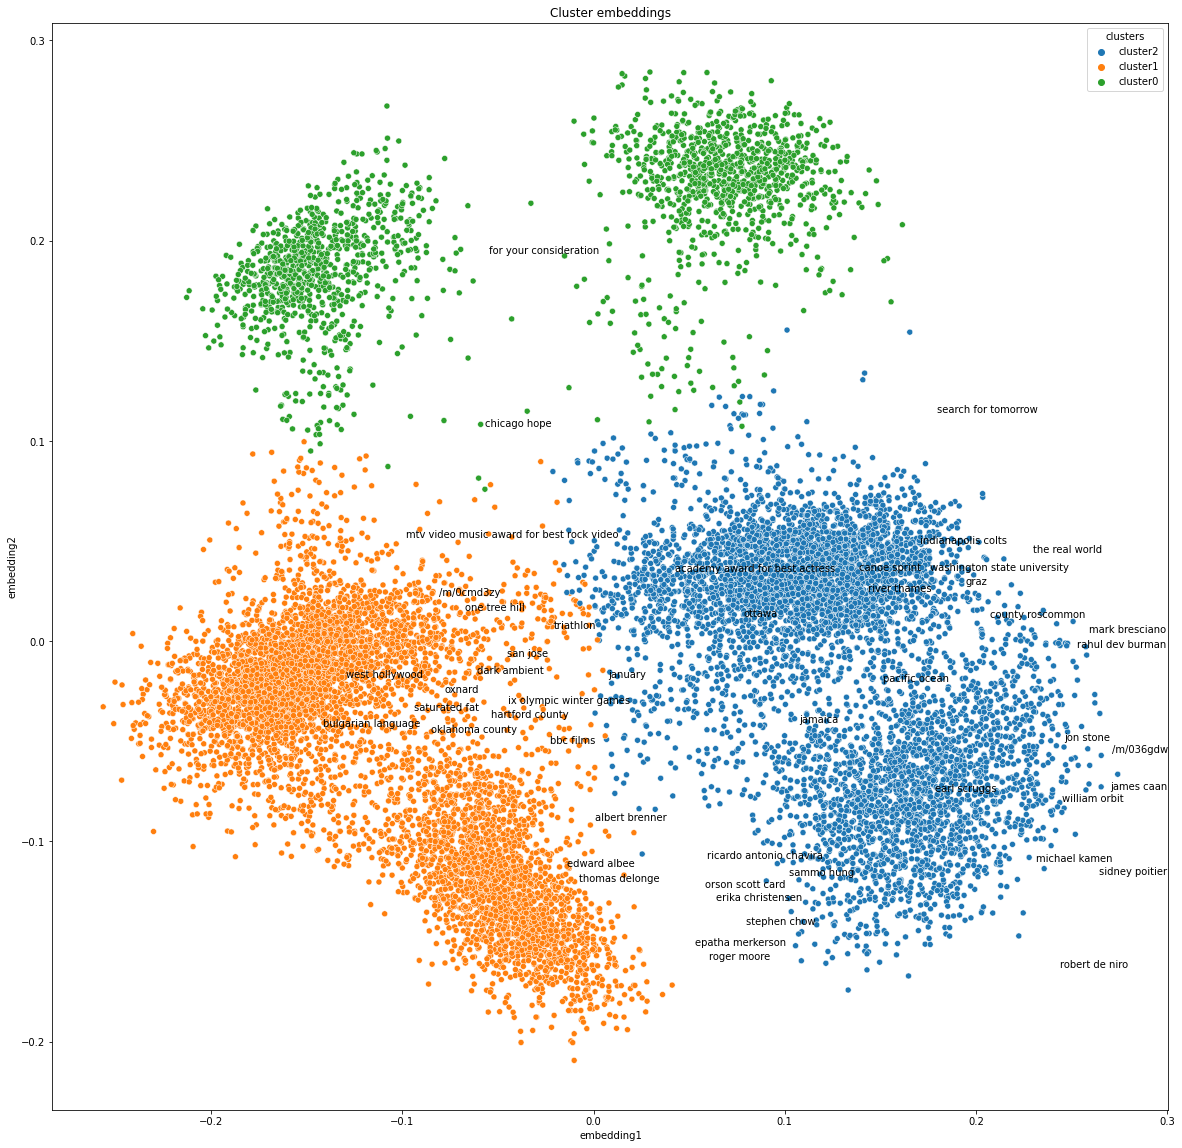

In [61]:
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd

# Get the embeddings (150 dims) for all the entities of interest
jobs_embeddings = model.get_embeddings(all_entities, embedding_type='entity')

# Perform PCA and reduce the dims to 2
embeddings_2d = PCA(n_components=2).fit_transform(np.array([emb for emb in jobs_embeddings]))

# Create a dataframe to plot the embeddings using scatterplot
df = pd.DataFrame({"entities": all_entities, "clusters": "cluster" + pd.Series(clusters).astype(str),
                    "embedding1": embeddings_2d[:, 0], "embedding2": embeddings_2d[:, 1]})

plt.figure(figsize=(20, 20))
plt.title("Cluster embeddings")

ax = sns.scatterplot(data=df, x="embedding1", y="embedding2", hue="clusters")

# Print only a few labels, to avoid clutter, using adjust_text.
from adjustText import adjust_text
texts = []
for i, point in df.iterrows():
    # randomly choose a few labels to be printed
    if np.random.uniform() < 0.003:
        texts.append(plt.text(point['embedding1']+.1, point['embedding2'], str(point['entities'])))
        
adjust_text(texts)
plt.show()

In [62]:
from ampligraph.discovery import discover_facts

triples, ranks = discover_facts(dataset.values, 
                                model, 
                                top_n=500, 
                                max_candidates=500, 
                                strategy='cluster_triangles', 
                                target_rel='/people/person/profession', 
                                seed=42)

for triple, rank in zip(triples, ranks):
    print('Rank: {} \t {} '.format(rank, triple))


WARNING - DeprecationWarning: use_default_protocol will be removed in future. Please use corrupt_side argument instead.


100%|████████████████████████████████████████████████████████████████████████████████| 500/500 [00:22<00:00, 21.84it/s]


Rank: 6.0 	 ['bob clampett' '/people/person/profession' 'actor'] 
Rank: 298.5 	 ['bob boyle' '/people/person/profession' 'actor'] 
Rank: 298.0 	 ['thomas newman' '/people/person/profession' 'actor'] 
Rank: 495.5 	 ['bob clampett' '/people/person/profession' 'family plot'] 


In [63]:
from ampligraph.utils import create_tensorboard_visualizations

model = restore_model('TransE.pkl')

create_tensorboard_visualizations(model, 'embeddings_transe')